In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps
import pickle
import sys
import time
import mlflow
import os
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as skl_classification_report

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
# checking pandas and numpy version
print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)

Pandas version:  2.2.2
Numpy version:  1.26.4


In [4]:
df = pd.read_csv('./data/Cars.csv')

In [5]:
# summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [6]:
# checking the data in the dataset
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


# Preparing the dataset

In [7]:
# checking unique values for the owner column
df['owner'].unique()

array(['First Owner', 'Second Owner', 'Third Owner',
       'Fourth & Above Owner', 'Test Drive Car'], dtype=object)

In [8]:
# mapping 'owner' column to appropriate values
owner_map = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
}

df['owner'] = df['owner'].map(owner_map)
df['owner'].unique()

array([1, 2, 3, 4, 5], dtype=int64)

In [9]:
# checking unique values for the fuel column
df['fuel'].unique()

array(['Diesel', 'Petrol', 'LPG', 'CNG'], dtype=object)

In [10]:
# selecting only Diesel and Petrol cars
df.drop(df[(df['fuel'] == 'LPG') | (df['fuel'] == 'CNG')].index, inplace = True)
df['fuel'].unique()

array(['Diesel', 'Petrol'], dtype=object)

In [11]:
# removing "kmpl" from mileage column
df['mileage'] = df['mileage'].str.replace('kmpl', '')
df['mileage'].head()

0     23.4 
1    21.14 
2     17.7 
3     23.0 
4     16.1 
Name: mileage, dtype: object

In [12]:
# changing the data type of mileage column to float
df['mileage'] = df['mileage'].astype(float)
df['mileage'].head()

0    23.40
1    21.14
2    17.70
3    23.00
4    16.10
Name: mileage, dtype: float64

In [13]:
# removing "CC" from engine column
df['engine'] = df['engine'].str.replace('CC', '')
df['engine'].head()

0    1248 
1    1498 
2    1497 
3    1396 
4    1298 
Name: engine, dtype: object

In [14]:
# changing the data type of engine column to float
df['engine'] = df['engine'].astype(float)
df['engine'].head()

0    1248.0
1    1498.0
2    1497.0
3    1396.0
4    1298.0
Name: engine, dtype: float64

In [15]:
# removing "bhp" from max_power column
df['max_power'] = df['max_power'].str.replace('bhp', '')
df['max_power'].head()

0        74 
1    103.52 
2        78 
3        90 
4      88.2 
Name: max_power, dtype: object

In [16]:
# changing the data type of max_power column to float
df['max_power'] = df['max_power'].astype(float)
df['max_power'].head()

0     74.00
1    103.52
2     78.00
3     90.00
4     88.20
Name: max_power, dtype: float64

In [17]:
# taking only the first word from the "name" column
df['name'] = df['name'].str.split().str.get(0)

In [18]:
# checking unique values for the name column
df['name'].unique()

array(['Maruti', 'Skoda', 'Honda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Tata', 'Chevrolet', 'Fiat', 'Datsun', 'Jeep',
       'Mercedes-Benz', 'Mitsubishi', 'Audi', 'Volkswagen', 'BMW',
       'Nissan', 'Lexus', 'Jaguar', 'Land', 'MG', 'Volvo', 'Daewoo',
       'Kia', 'Force', 'Ambassador', 'Ashok', 'Isuzu', 'Opel', 'Peugeot'],
      dtype=object)

In [19]:
# dropping the 'torque' column
df.drop('torque', axis = 1, inplace = True)

In [20]:
# removing rows with owner value of 5 i.e., 'Test Drive Car'
df.drop(df[df['owner'] == 5].index, inplace = True)

# Exploratory Data Analysis (EDA)

Examining and visualizing data to understand its main characteristics and identify any patterns.

In [21]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,5.0
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,5.0
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,5.0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,5.0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,5.0


### Distribution plot

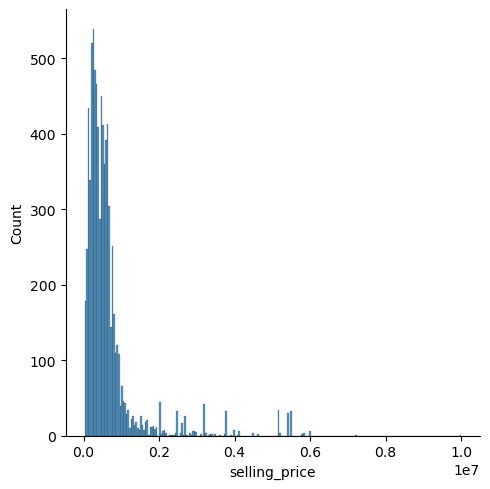

In [22]:
# checking the distribution of selling_price
# selling price is found to be right skewed
sns.displot(df['selling_price'])
plt.show()

### Scatter Plots 

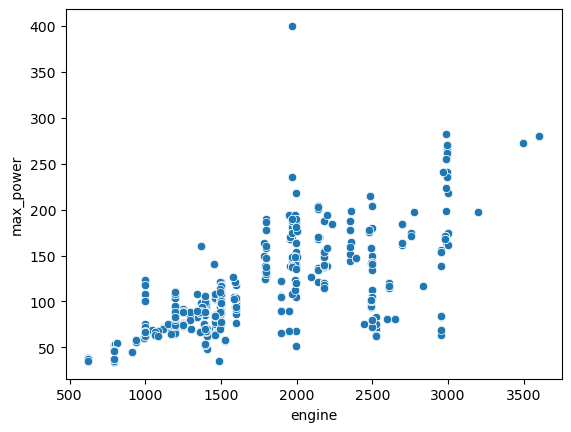

In [23]:
# as the engine CC increases, max power of the car is also found to increase
# showing a positive correlation between engine and max_power
sns.scatterplot(x='engine', y='max_power', data=df)
plt.show()

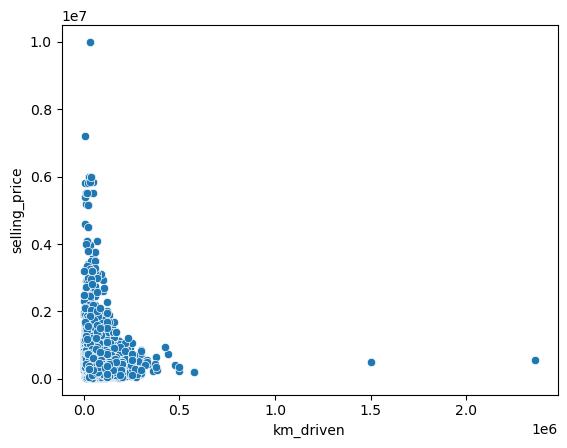

In [24]:
# km_driven vs selling_price
# the selling price of the cars decreases as the km driven increases
sns.scatterplot(x='km_driven', y='selling_price', data=df)
plt.show()

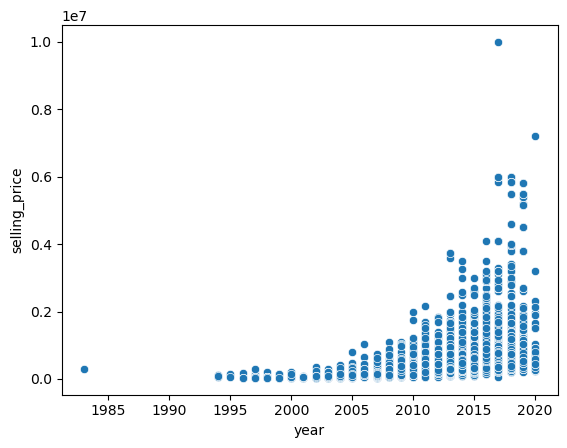

In [25]:
# year vs selling_price
# the selling price of the cars increases as the year increases
sns.scatterplot(x='year', y='selling_price', data=df)
plt.show()

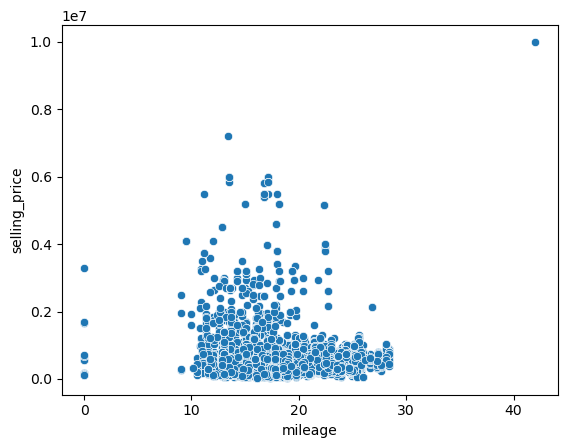

In [26]:
# mileage vs selling_price
# a lot of cars in the dataset have moderate to low mileage
sns.scatterplot(x='mileage', y='selling_price', data=df)
plt.show()

### One-hot encoding
One hot encoding the 'seller_type' category as there is no natural ordering and to represent it as numerical value

In [27]:
# checking unique values for the seller type
df['seller_type'].unique()

array(['Individual', 'Dealer', 'Trustmark Dealer'], dtype=object)

In [28]:
# using all three columns to check predictive power score and correlation during EDA

df_encoded = pd.get_dummies(df, columns=['seller_type'])
df_encoded.head()

,name,year,selling_price,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer
0,Maruti,2014,450000,145500,Diesel,Manual,1,23.40,1248.0,74.00,5.0,False,True,False
1,Skoda,2014,370000,120000,Diesel,Manual,2,21.14,1498.0,103.52,5.0,False,True,False
2,Honda,2006,158000,140000,Petrol,Manual,3,17.70,1497.0,78.00,5.0,False,True,False
3,Hyundai,2010,225000,127000,Diesel,Manual,1,23.00,1396.0,90.00,5.0,False,True,False
4,Maruti,2007,130000,120000,Petrol,Manual,1,16.10,1298.0,88.20,5.0,False,True,False


In [29]:
# initialising label encoder
le = LabelEncoder()

In [30]:
df['fuel'].unique()

array(['Diesel', 'Petrol'], dtype=object)

In [31]:
# label encoding the fuel column
df_encoded['fuel'] = le.fit_transform(df_encoded['fuel'])

In [32]:
# Check the mapping
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Diesel': 0, 'Petrol': 1}


In [33]:
df['transmission'].unique()


array(['Manual', 'Automatic'], dtype=object)

In [34]:
# label encoding the transmission column
df_encoded['transmission'] = le.fit_transform(df_encoded['transmission'])

In [35]:
# Check the mapping
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Automatic': 0, 'Manual': 1}


### Correlation matrix
Checking correlation between features to understand the strength and direction of relationships between different variables in the dataset

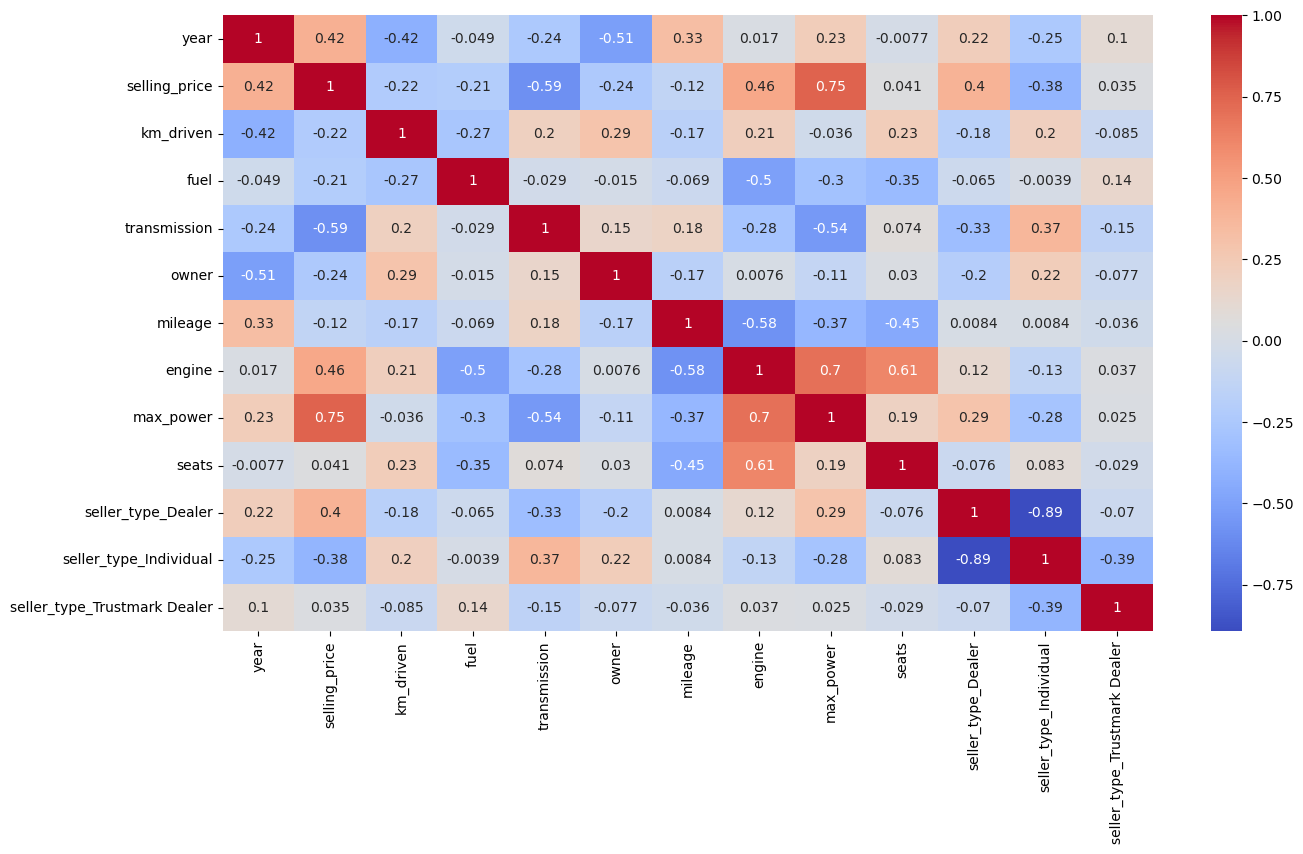

In [36]:
# Note:
# engine and max_power seem to have a high correlation with each other
# so, we can choose one of them for our model
# year seems to have a positive correlation with selling_price
# km_driven seems to have a negative correlation with selling_price

plt.figure(figsize = (15, 8))
sns.heatmap(df_encoded.drop('name', axis=1).corr(), annot = True, cmap = 'coolwarm')
plt.show()

### Predictive Power Score

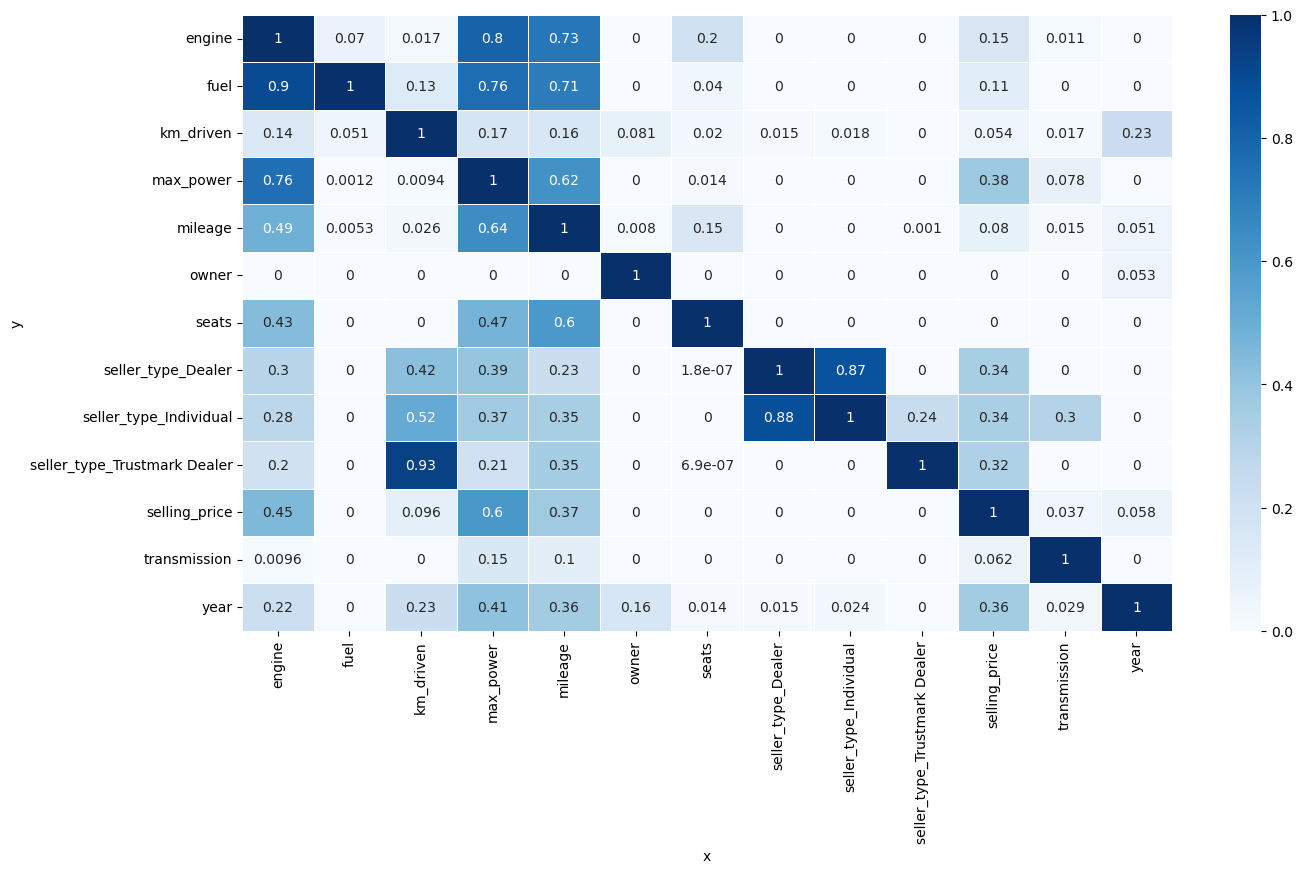

In [37]:
df_encoded_pps= df_encoded.copy()
df_encoded_pps.drop('name', axis = 1, inplace = True)

matrix = pps.matrix(df_encoded_pps)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

plt.figure(figsize=(15, 8))
sns.heatmap(matrix, vmin = 0, vmax = 1, cmap = 'Blues', linewidths=0.5, annot = True)
plt.show()

# Binning

In [38]:
df_encoded['selling_price'].describe()

count    8.028000e+03
mean     6.403937e+05
std      8.027015e+05
min      2.999900e+04
25%      2.600000e+05
50%      4.500000e+05
75%      6.800000e+05
max      1.000000e+07
Name: selling_price, dtype: float64

In [39]:
df_encoded['selling_price'] = pd.cut(df_encoded['selling_price'], bins = 4, labels = [0, 1, 2, 3], include_lowest = True)

In [40]:
df_encoded['selling_price'].value_counts()

selling_price
0    7732
1     182
2     113
3       1
Name: count, dtype: int64

# Feature Selection

Identifying and selecting the most relevant variables to improve model performance

In [41]:
X = df_encoded[['year', 'engine', 'km_driven', 'mileage']]
assert len(X.shape) == 2

In [42]:
y = df_encoded['selling_price']
assert len(y.shape) == 1

Splitting the dataset into training and testing set.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)

# Preprocessing

### Null Values
Addressing missing data through methods like imputation

In [44]:
# checking for missing values
X_train.isna().sum()

year           0
engine       151
km_driven      0
mileage      151
dtype: int64

<Axes: >

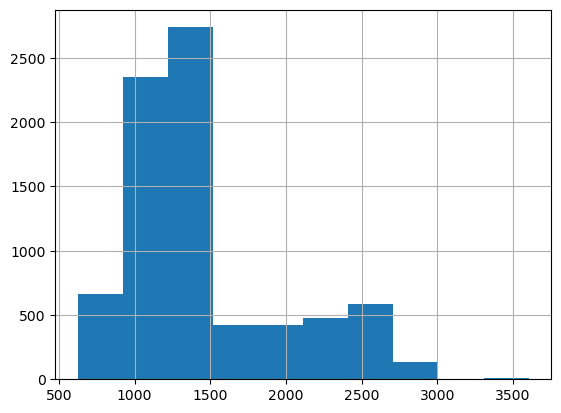

In [45]:
# checking distribution of engine feature
df_encoded['engine'].hist()

In [46]:
# checking mean and median
df_encoded['engine'].describe()

count    7814.000000
mean     1462.914640
std       504.759742
min       624.000000
25%      1197.000000
50%      1248.000000
75%      1582.000000
max      3604.000000
Name: engine, dtype: float64

In [47]:
# replacing missing values with median
X_train.fillna({'engine': X_train['engine'].median()}, inplace = True)

<Axes: >

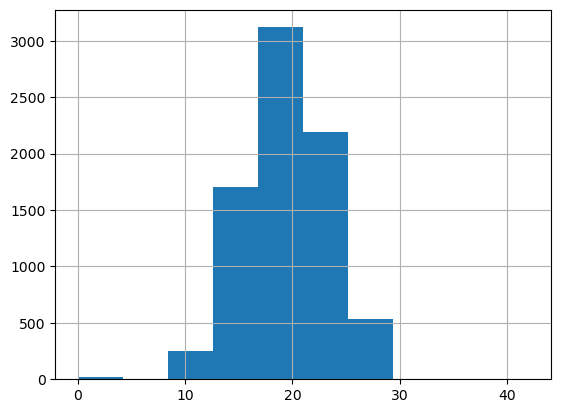

In [48]:
# checking distribution of mileage feature
df_encoded['mileage'].hist()

In [49]:
# checking mean and median
df_encoded['mileage'].describe()

count    7814.000000
mean       19.391962
std         4.001972
min         0.000000
25%        16.780000
50%        19.300000
75%        22.320000
max        42.000000
Name: mileage, dtype: float64

In [50]:
# replacing missing values with mean
X_train['mileage'].fillna(X_train['mileage'].mean(), inplace = True)

In [51]:
# confirming no missing values are present
X_train.isna().sum()

year         0
engine       0
km_driven    0
mileage      0
dtype: int64

In [52]:
# checking for null values
y_train.isna().sum()

0

In [53]:
# checking number of rows
X_train.shape, y_train.shape

((5378, 4), (5378,))

In [54]:
# checking for missing values
X_test.isna().sum()

year          0
engine       63
km_driven     0
mileage      63
dtype: int64

In [55]:
# replacing missing values with median from training dataset
X_test['engine'].fillna(X_train['engine'].median(), inplace = True)

In [56]:
# replacing missing values with mean from training dataset
X_test['mileage'].fillna(X_train['mileage'].mean(), inplace = True)

In [57]:
# confirming no missing values are present
X_test.isna().sum()

year         0
engine       0
km_driven    0
mileage      0
dtype: int64

In [58]:
y_test.isna().sum()

0

In [59]:
# checking number of rows
X_test.shape, y_test.shape

((2650, 4), (2650,))

### Checking for outliers

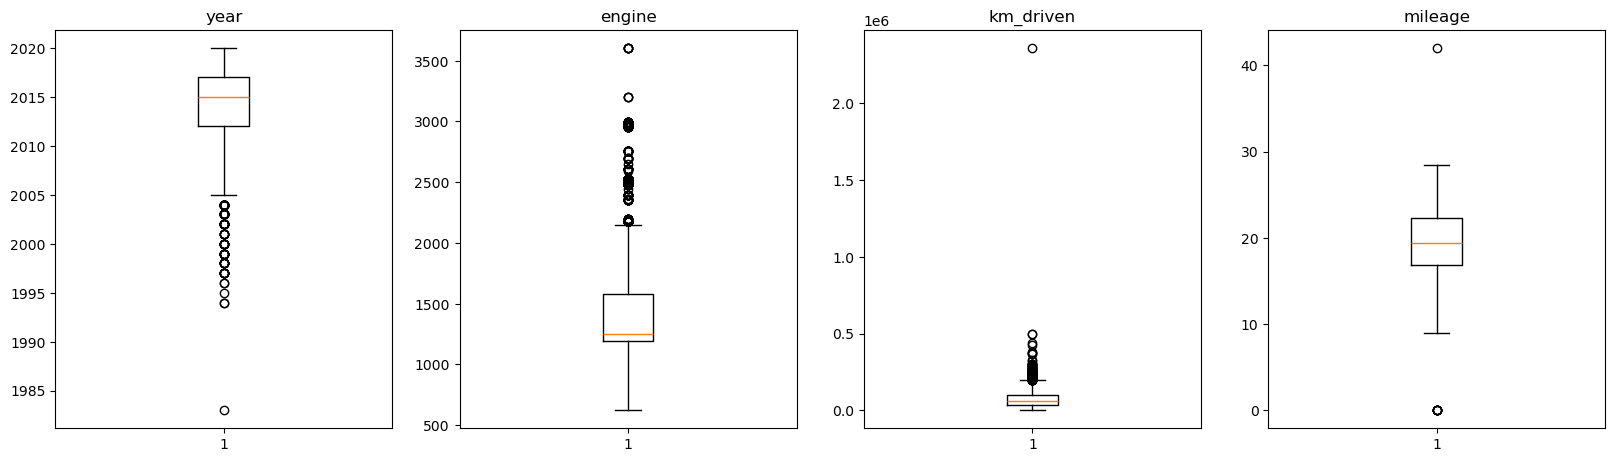

In [60]:
col_dict = {'year':1,'engine':2, 'km_driven':3, 'mileage':4}

# checking outliers
plt.figure(figsize=(20,30))

for variable,i in col_dict.items():
                     plt.subplot(5,4,i)
                     plt.boxplot(X_train[variable])
                     plt.title(variable)

plt.show()

In [61]:
def outlier_count(col, data = X_train):
    
    # calculating 25% quartile and 75% quartile
    q75, q25 = np.percentile(data[col], [75, 25])
    
    # calculating IQR
    iqr = q75 - q25
    
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    
    # calculate the percentage of the outliers
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    
    if(outlier_count > 0):
        print("\n"+15*'-' + col + 15*'-'+"\n")
        print('Number of outliers: {}'.format(outlier_count))
        print('Percent of data that is outlier: {}%'.format(outlier_percent))

In [62]:
for col in X_train.columns:
    outlier_count(col)


---------------year---------------

Number of outliers: 144
Percent of data that is outlier: 2.68%

---------------engine---------------

Number of outliers: 810
Percent of data that is outlier: 15.06%

---------------km_driven---------------

Number of outliers: 110
Percent of data that is outlier: 2.05%

---------------mileage---------------

Number of outliers: 8
Percent of data that is outlier: 0.15%


### Scaling

In [63]:
# Define a list of numerical feature names that need to be scaled
num_cols = ['year', 'engine', 'km_driven', 'mileage']

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [64]:
# one hot encoding to avoid ordinal relationships
Y_train_encoded = pd.get_dummies(y_train)

In [65]:
# add intercept to our X
# intercept = np.ones((X_train.shape[0], 1))
# X_train   = np.concatenate((intercept, X_train), axis=1)  #add intercept
# intercept = np.ones((X_test.shape[0], 1))
# X_test    = np.concatenate((intercept, X_test), axis=1)  #add intercept

In [66]:
X_train = X_train.to_numpy()
X_test  = X_test.to_numpy()
Y_train_encoded = Y_train_encoded.to_numpy()
y_test  = y_test.to_numpy()

In [67]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", Y_train_encoded.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (5378, 4)
Shape of y_train:  (5378, 4)
Shape of X_test:  (2650, 4)
Shape of y_test:  (2650,)


# Modeling

In [68]:
mlflow.set_tracking_uri("http://mlflow.ml.brain.cs.ait.ac.th/")

os.environ["MLFLOW_TRACKING_USERNAME"] = "admin"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "password"
os.environ["LOGNAME"] = "st125287-a3"

mlflow.set_experiment(experiment_name="st125287-a3")

<Experiment: artifact_location='mlflow-artifacts:/663142848325805855', creation_time=1727595751760, experiment_id='663142848325805855', last_update_time=1727595751760, lifecycle_stage='active', name='st125287-a3', tags={}>

In [69]:
class LogisticRegression:
    
    def __init__(self, regularization, k, n, method, alpha = 0.001, max_iter=5000):
        self.regularization = regularization
        self.k = k
        self.n = n
        self.alpha = alpha
        self.max_iter = max_iter
        self.method = method
    
    def fit(self, X, Y):
        self.W = np.random.rand(self.n, self.k)
        self.losses = []
        
        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad =  self.gradient(X, Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")
            
        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                ix = np.random.randint(0, X.shape[0]) #<----with replacement
                batch_X = X[ix:ix+batch_size]
                batch_Y = Y[ix:ix+batch_size]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")
            
        elif self.method == "sto":
            start_time = time.time()
            list_of_used_ix = []
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])
                while i in list_of_used_ix:
                    idx = np.random.randint(X.shape[0])
                X_train = X[idx, :].reshape(1, -1)
                Y_train = Y[idx]
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                
                list_of_used_ix.append(i)
                if len(list_of_used_ix) == X.shape[0]:
                    list_of_used_ix = []
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")
            
        else:
            raise ValueError('Method must be one of the followings: "batch", "minibatch" or "sto".')
        
        
    def gradient(self, X, Y):
        m = X.shape[0]
        h = self.h_theta(X, self.W)
        # print("h value: ", h)
        loss = - np.sum(Y*np.log(h)) / m
        error = h - Y
        
        if self.regularization:
            grad = self.softmax_grad(X, error) + self.regularization.derivation(self.W)
        else:
            grad = self.softmax_grad(X, error)

        return loss, grad

    def softmax(self, theta_t_x):
        return np.exp(theta_t_x) / np.sum(np.exp(theta_t_x), axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        return  X.T @ error

    def h_theta(self, X, W):
        '''
        Input:
            X shape: (m, n)
            w shape: (n, k)
        Returns:
            yhat shape: (m, k)
        '''
        return self.softmax(X @ W)
    
    def predict(self, X_test):
        return np.argmax(self.h_theta(X_test, self.W), axis=1)
    
    def plot(self):
        plt.plot(np.arange(len(self.losses)) , self.losses, label = "Train Losses")
        plt.title("Losses")
        plt.xlabel("epoch")
        plt.ylabel("losses")
        plt.legend()

    def accuracy(self, y, y_pred):
        accuracy = 0

        correct_predictions = np.sum(y == y_pred)
        total_predictions = len(y)
        accuracy = correct_predictions / total_predictions
        
        return accuracy
    
    def precision(self, y, y_pred, c = 0):
        precision = 0
        
        # actually 'c' and predicted 'c'
        true_positives = np.sum((y == c) & (y_pred == c))

        # not actually 'c' but predicted 'c'
        false_positives = np.sum((y != c) & (y_pred == c))

        # checking if denomintor is not zero
        if (true_positives + false_positives) == 0:
            return precision
        
        precision = true_positives / (true_positives + false_positives)
        
        return precision
    
    def recall(self, y, y_pred, c = 0):
        recall = 0
        
        # actually 'c' and predicted 'c'
        true_positives = np.sum((y == c) & (y_pred == c))

        # actually 'c' but predicted not 'c'
        false_negatives = np.sum((y == c) & (y_pred != c))

        # checking if denomintor is not zero
        if (true_positives + false_negatives) == 0:
            return recall
        
        recall = true_positives / (true_positives + false_negatives)
        
        return recall
    
    def f1_score(self, y, y_pred, c = 0):
        precision = self.precision(y, y_pred, c)
        recall = self.recall(y, y_pred, c)

        # checking if denomintor is not zero
        if (precision + recall) == 0:
            return 0
        
        f1_score = 2 * (precision * recall) / (precision + recall)
        
        return f1_score
    
    def macro_precision(self, y, y_pred):
        precision_sum = [self.precision(y, y_pred, c) for c in range(self.k)]

        macro_precision = np.sum(precision_sum) / self.k

        return macro_precision
    
    def macro_recall(self, y, y_pred):
        recall_sum = [self.recall(y, y_pred, c) for c in range(self.k)]

        macro_recall = np.sum(recall_sum) / self.k

        return macro_recall
    
    def macro_f1_score(self, y, y_pred):
        f1_sum = [self.f1_score(y, y_pred, c) for c in range(self.k)]

        macro_f1 = np.sum(f1_sum) / self.k

        return macro_f1

    def weighted_precision(self, y, y_pred):
        precision_sum = [self.precision(y, y_pred, c) for c in range(self.k)]

        # going through every class
        # [0, 1, 2, 1, 2, 1, 0] and if k = 3
        # so for, c = 0
        # [True, False, False, False, False, False, True]
        # OP: 2 -> then go to another class
        class_count = [np.sum(y == c) for c in range(self.k)]

        weighted_precision = np.sum([precision_sum[i] * class_count[i] for i in range(self.k)]) / len(y)

        return weighted_precision

    def weighted_recall(self, y, y_pred):
        recall_sum = [self.recall(y, y_pred, c) for c in range(self.k)]
        class_count = [np.sum(y == c) for c in range(self.k)]

        weighted_recall = np.sum(recall_sum[i] * class_count[i] for i in range(self.k)) / len(y)

        return weighted_recall
    
    def weighted_f1(self, y, y_pred):
        f1_sum = [self.f1_score(y, y_pred, c) for c in range(self.k)]
        class_count = [np.sum(y == c) for c in range(self.k)]

        weighted_f1 = np.sum(f1_sum[i] * class_count[i] for i in range(self.k)) / len(y)

        return weighted_f1

    def classification_report(self, y, y_pred):
        cols = ["precision", "recall", "f1-score"]
        idx = list(range(self.k)) + ["accuracy", "macro", "weighted"]

        report = [[self.precision(y, y_pred, c),
                   self.recall(y, y_pred, c),
                   self.f1_score(y, y_pred, c)] for c in range(self.k)]

        report.append(["", "", self.accuracy(y, y_pred)])

        report.append([self.macro_precision(y, y_pred),
                       self.macro_recall(y, y_pred),
                       self.macro_f1_score(y, y_pred)])

        report.append([self.weighted_precision(y, y_pred),
                       self.weighted_recall(y, y_pred),
                       self.weighted_f1(y, y_pred)])

        return pd.DataFrame(report, index=idx, columns=cols)

Checking with dummy data

In [70]:
np.random.seed(42)
y_check = np.array([0, 1, 0, 2, 1, 0, 2, 1, 2, 2, 1, 0] )  # Actual labels (0, 1, 2)
y_pred_check = np.array([0, 0, 0, 2, 1, 0, 2, 1, 0, 2, 1, 1])  # Predicted labels (0, 1, 2)

my_lr = LogisticRegression(regularization=None, k = 3, n = 5, method = "batch")

custom_report = my_lr.classification_report(y_check, y_pred_check)
print("\nCustom Classification Report:")
print(custom_report)


Custom Classification Report:
         precision recall  f1-score
0              0.6   0.75  0.666667
1             0.75   0.75  0.750000
2              1.0   0.75  0.857143
accuracy                   0.750000
macro     0.783333   0.75  0.757937
weighted  0.783333   0.75  0.757937


In [71]:
print(skl_classification_report(y_check, y_pred_check))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.75      0.75      0.75         4
           2       1.00      0.75      0.86         4

    accuracy                           0.75        12
   macro avg       0.78      0.75      0.76        12
weighted avg       0.78      0.75      0.76        12



Here, support 4 means the actual occurences of each class in the dataset. For example: Support 4 for class '0' means, there is 4 samples of class '0' in the dataset.

In [72]:
class RidgePenalty:
    
    def __init__(self, l):
        self.l = l
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.square(theta))
        
    def derivation(self, theta):
        return self.l * 2 * theta
    
class Ridge(LogisticRegression):
    def __init__(self, l, k, n, method, alpha = 0.001, max_iter=5000):
        self.regularization = RidgePenalty(l)
        super().__init__(self.regularization, k=k, n=n, method=method, alpha=alpha, max_iter=max_iter)

class Normal(LogisticRegression):
    def __init__(self, k, n, method, alpha=0.001, max_iter=5000):
        super().__init__(regularization=None, k=k, n=n, method=method, alpha=alpha, max_iter=max_iter)

In [73]:
def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

### Experiment

In [74]:
k = len(set(y))
k

4

In [75]:
regs = ["Normal", "Ridge"]
methods = ["batch", "minibatch", "sto"]
alphas = [0.01, 0.001, 0.0001]
best_model = None
best_train_loss = float('inf')
best_reg_name = ""
best_method = ""

try:
    for reg in regs:
        for method in methods:
            with mlflow.start_run(run_name=f"reg-{reg}-method-{method}", nested=True):

                for alpha in alphas:
                    if reg == "Normal":
                        params = {"k": k, "n":X_train.shape[1], "method": method, "alpha": alpha, "max_iter": 9000}
                    else:
                        params = {"k": k, "n":X_train.shape[1], "method": method, "l": 0.1, "alpha": alpha, "max_iter": 9000}
                    
                    with mlflow.start_run(run_name=f"reg-{reg}-method-{params['method']}-alpha-{params['alpha']}", nested=True):
                        print("="*30)
                        print(reg, method)
                        print(f"alpha: {alpha}")
                        print("="*30)
                        type_of_regression = str_to_class(reg)
                        model = type_of_regression(**params)  
                        model.fit(X_train, Y_train_encoded)
                        yhat = model.predict(X_test)

                        accuracy = model.accuracy(y_test, yhat)
                        mlflow.log_metric(key="accuracy", value=accuracy)

                        for c in range(k):
                            f1 = model.f1_score(y_test, yhat, c)
                            precision = model.precision(y_test, yhat, c)
                            recall = model.recall(y_test, yhat, c)
                            mlflow.log_metric(key=f"class_{c}_f1", value=f1)
                            mlflow.log_metric(key=f"class_{c}_recall", value=recall)
                            mlflow.log_metric(key=f"class_{c}_precision", value=precision)
                        
                        final_train_loss = model.losses[-1]
                        print(f"Final Training Loss: {final_train_loss}")
                        
                        if final_train_loss < best_train_loss:
                            best_train_loss = final_train_loss
                            best_model = model
                            best_reg_name = reg
                            best_method = method

                        signature = mlflow.models.infer_signature(X_train, model.predict(X_train))
                        mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)                

            mlflow.end_run()

    mlflow.end_run()
except Exception as e:
    print("Exception: ", e)

Normal batch
alpha: 0.01
Loss at iteration 0 1.5229543452368304
Loss at iteration 500 14.504224771474732
Loss at iteration 1000 14.504224771474737
Loss at iteration 1500 14.504224771474734
Loss at iteration 2000 14.504224771474734
Loss at iteration 2500 14.504224771474737
Loss at iteration 3000 14.504224771474728
Loss at iteration 3500 14.504224771474734
Loss at iteration 4000 14.504224771474734
Loss at iteration 4500 14.504224771474737
Loss at iteration 5000 14.504224771474732
Loss at iteration 5500 14.504224771474732
Loss at iteration 6000 14.504224771474728
Loss at iteration 6500 14.504224771474734
Loss at iteration 7000 14.504224771474728
Loss at iteration 7500 14.504224771474734
Loss at iteration 8000 14.504224771474732
Loss at iteration 8500 14.504224771474734
time taken: 6.024520635604858
Final Training Loss: 15.052146015142553
Normal batch
alpha: 0.001
Loss at iteration 0 1.441348846714779
Loss at iteration 500 1.5627527191922705
Loss at iteration 1000 1.5627527191922705
Loss a

In [76]:
print("Best model:")
print("Regularization", best_reg_name)
print("Method", best_method)
print("Final Training loss", best_train_loss)

# best model <__main__.Ridge object at 0x0000022127485550>
# best train loss 1.3626104918337973
# best reg name Ridge
# best method minibatch

# best model <__main__.Ridge object at 0x000002313132C090>
# best train loss 1.0943840437050447
# best reg name Ridge
# best method sto

Best model:
Regularization Ridge
Method sto
Final Training loss 1.0943840437050447


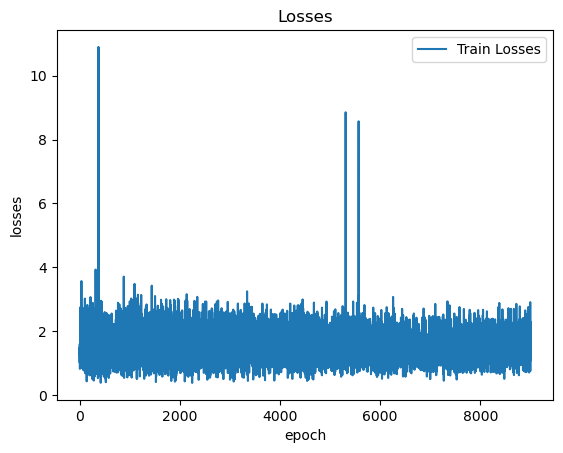

In [78]:
# Visualizing the loss graph
best_model.plot()
plt.show()

In [79]:
yhat = best_model.predict(X_test)

# Custom classification report
custom_classification_report = best_model.classification_report(y_test, yhat)
print("*" * 6, "Custom Classification report", "*" * 6)
print(custom_classification_report)

# Sklearn's classification report
sklearn_report = skl_classification_report(y_test, yhat)
print("\n")
print("*" * 6, "Sklearn's Classification report", "*" * 6)
print(sklearn_report)

****** Custom Classification report ******
         precision    recall  f1-score
0              1.0  0.493542  0.660901
1         0.036554      0.25  0.063781
2              0.0       0.0  0.000000
3              0.0         0  0.000000
accuracy                      0.481132
macro     0.259138  0.185886  0.181171
weighted  0.964923  0.481132  0.638557


****** Sklearn's Classification report ******
              precision    recall  f1-score   support

           0       1.00      0.49      0.66      2555
           1       0.04      0.25      0.06        56
           2       0.00      0.00      0.00        39
           3       0.00      0.00      0.00         0

    accuracy                           0.48      2650
   macro avg       0.26      0.19      0.18      2650
weighted avg       0.96      0.48      0.64      2650



# Inference

In [83]:
model_path = 'model/a3_model.model'
pickle.dump(best_model, open(model_path, 'wb'))

In [84]:
scaler_path = 'model/a3_scaler.model'
pickle.dump(scaler, open(scaler_path, 'wb'))

In [85]:
loaded_model = pickle.load(open(f"{model_path}", 'rb'))

In [86]:
model_name = "st125287-a3-model"
model_version = 1

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

In [87]:
precited_selling_price= model.predict(pd.DataFrame(X_test))
precited_selling_price[:15]

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [88]:
# The actual values of y
y_test[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [91]:
local_model = pickle.load(open(f"{model_path}", 'rb'))
loaded_model.predict(X_test[:1])

array([3], dtype=int64)